In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import AEAFX
from IPython.display import Audio
from torch import Tensor
import torch.utils.data
from train_ddx7_56 import (
    mel_loss,
    mfcc_loss,
    metrics_dict,
    OT_loss,
    DDX7Loss,
    OT_comp_loss,
    OT_RMS_loss,
    mrstft_revisited,
    get_model,
)
import lightning.pytorch as pl
import os
from tqdm import tqdm
import yaml

import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.special import gamma
import scipy.signal as sig
import scipy.io.wavfile
import nnAudio.features
from time import time


if torch.cuda.is_available():
    accelerator = "gpu"
    device = "cuda:0"
else:
    accelerator = "cpu"
    device = "cpu"

print(device)


class NamedLoss:
    def __init__(self, loss, name: str, lowerisbetter: bool = True):
        self.loss = loss
        self.name = name
        self.lowerisbetter = lowerisbetter

    def __call__(self, x, y):
        return self.loss(x, y)


metrics_dict = {
    "SOT": OT_comp_loss,
    "MR-STFT rev": mrstft_revisited,
    "neg SI-SDR":AEAFX.loss.neg_sisdr,
    "Mel":mel_loss,
    "MFCC": mfcc_loss
}

loss_safe = OT_comp_loss
mel_loss = NamedLoss(mel_loss, "Mel")
OT_comp_loss = NamedLoss(OT_comp_loss, "SOT")
mrstft_revisited = NamedLoss(mrstft_revisited, "MR-STFT")
sisdr = NamedLoss(AEAFX.loss.si_sdr, "SI-SDR", lowerisbetter=False)



class NamedData:
    def __init__(self, data: Tensor, name: str):
        self.data = data
        self.name = name


def cosine_sim_mat(mat: Tensor):
    mat1 = mat.unsqueeze(0)
    mat2 = mat.unsqueeze(1)

    top = (mat1 * mat2).sum(2)
    bot = mat1.square().sum(2).sqrt() * mat2.square().sum(2).sqrt()
    return top / bot


losses_fn_list = [mel_loss, OT_comp_loss, sisdr]

def get_model_from_name(path: str, fx, device):
	with open(path + ".yaml", "r") as f:
		cfg = yaml.safe_load(f)

	model = get_model(cfg, fx, fx)
	if device=="cpu":
		p=torch.load(path + ".pt", map_location=torch.device('cpu'))
	else:
		p=torch.load(path + ".pt", )
	
	model.load_state_dict(p, strict=False)
	if isinstance(model, AEAFX.models.FX_Inference):
		model.base_distrib.base_entropy = "MC"
	model = model.to(device).eval()
	return model

CQT kernels created, time used = 0.0315 seconds
cuda:0


c:\Users\pelad\miniconda3\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [2]:
note_pitch = 110
samplerate = 44100
norm = "log"

In [3]:

ds = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
    samplerate=samplerate,
    audio_length_s=2,
    note_pitch=note_pitch,
    ratio_normalization=norm,
    min_freq_arg=0.5,
    max_freq_arg=10,
)
print(ds.kept_idx)

min_ratio = ds.min_freq_ratio
max_ratio = ds.max_freq_ratio
print(min_ratio, max_ratio)

[83, 999, 2284, 2986, 4550, 4552, 6342, 12844, 12981, 14680, 18287, 18769, 18770, 20105, 21590, 22669, 24088, 25183, 25230, 25231, 26970, 26984, 27024, 27508, 28008]
0.5 10


In [4]:

ddx7 = AEAFX.ddafx.ddx7.DDX7_algo56_simple(
    base_freq=note_pitch,
    mod_max=12.57,
    min_ratio=min_ratio,
    max_ratio=10,
    samplerate=samplerate,
    ratio_norm=norm,
)

In [5]:
idx = 23

print(len(ds))
x, v = ds[idx]
print(v)

y = ddx7(x.unsqueeze(0), v.unsqueeze(0)).squeeze()

y_np = y.numpy()
Audio(data=y_np, rate=samplerate)

25
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9697, 1.0000, 0.2314, 0.2314, 0.2314])


In [47]:
ds = AEAFX.data.SelfGenDataset_DX7(
    audio_length=int(samplerate *1),
    ds_length=25,
    num_params=9,
    num_amps=6,
    skew_amp_distrib=1,
)
ds_name="rand"

# ds = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
# 	samplerate=samplerate,
# 	audio_length_s=1,
# 	note_pitch=note_pitch,
# 	ratio_normalization=norm,
# 	min_freq_arg=.5,
# 	max_freq_arg=10,
# )
# ds_name="lv"


STFT kernels created, time used = 0.0609 seconds


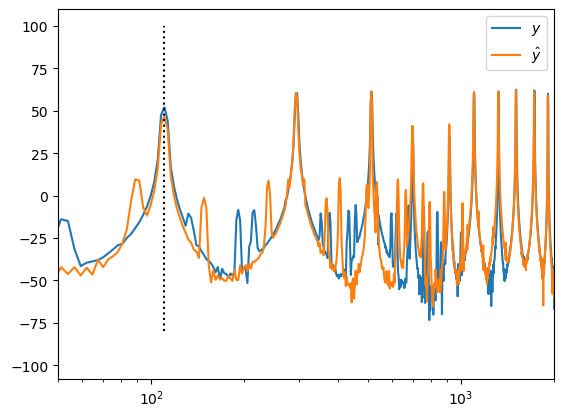

In [62]:
idx = 7
# idx = 14

cqt = nnAudio.features.CQT1992v2(
    sr=samplerate,
    hop_length=512,
    fmin=100,
    fmax=20000,
    bins_per_octave=20,
    filter_scale=0.5,
    verbose=False,
).to(device)

model_dir = "logs/ddx7_56"
model_name = "deter"
# model_name='gauss-1-ann'
# model_name='gauss-2-ann'
# model_name='mog-full-6-ann'
# model_name='mog-unif-6-ann'
# model_name='mog-unif-24-ann'
# model_name='gauss-1-noann'
# model_name='gauss-2-noann'
# model_name='mog-full-6-noann'
# model_name='mog-unif-6-noann'
# model_name='mog-unif-24-noann'
# model_name='synthperm-p2t'
# model_name='synthperm-ffn'
# model_name='mog-full-vae'
# model_name='vae'


# ds_name="rand"
# ds_name="lv"

name = os.path.join(model_dir, model_name)
ae = get_model_from_name(name, ddx7, device)

# print(ae.base_distrib)
with torch.no_grad():
    x, v = ds[idx]
    if ds_name == "rand":
        v = torch.tensor(
            [0.9823, 0.8964, 0.0776, 0.9609, 0.2454, 0.1496, 0.6663, 0.1297, 0.5862]
        )
    # print(v)
    x = x.unsqueeze(0)

    y = ddx7(x, v.unsqueeze(0))
    y = y - y.mean()

    x = x.to(device)
    y = y.to(device)
    v = v.to(device)
    ae = ae.to(device)

    for i in range(3):
        yhat_MAP = None
        if isinstance(ae, AEAFX.models.FX_AE):
            z = ae.get_FXParams(y)
        elif isinstance(ae, AEAFX.models.FX_Inference):
            ae: AEAFX.models.FX_Inference
            z = ae.get_FXParams_most_likely(y, K=1, return_logprob=False)
            z_MAP = ae.get_FXParams_most_likely(y, K=10000, return_logprob=False)
            yhat_MAP = ddx7(x, z)
            yhat_MAP = yhat_MAP.squeeze().cpu().numpy()
        elif isinstance(ae, AEAFX.models.SynthPerm):
            ae: AEAFX.models.SynthPerm
            z = ae.get_FXParams(y)
        # z = wta.get_FXParams(x, y)[:,0,:]
        # print(z)
        yhat = ddx7(x, z)

        yhat = yhat - yhat.mean()

        y_cqt = cqt(y)[:, 0].squeeze().cpu().numpy()
        # print(OT_comp_loss(y, yhat).mean())

        yhat = yhat.squeeze().cpu().numpy()

        scipy.io.wavfile.write(
            f"audio_save/ddx7/{ds_name}/{model_name}_{i}.wav", samplerate, yhat
        )
    if yhat_MAP is not None:
        scipy.io.wavfile.write(
        f"audio_save/ddx7/{ds_name}/{model_name}_MAP.wav", samplerate, yhat_MAP
    )

    y = y.squeeze().cpu().numpy()
    scipy.io.wavfile.write(f"audio_save/ddx7/{ds_name}/GT.wav", samplerate, y)
    # print(ddx7.denormalize_parameters(v.unsqueeze(0)))
    # print(ddx7.denormalize_parameters(z))

# print(y_cqt.shape)


display(Audio(data=y, rate=samplerate))
display(Audio(data=yhat, rate=samplerate))


def dB20(x):
    return 20 * np.log10(np.abs(x))


n_fft = 8192 * 2
# n_fft = 2048
win = sig.windows.hann(n_fft)

y_fft = np.fft.rfft(y, n=n_fft)
f = np.fft.rfftfreq(n=n_fft, d=1 / samplerate)

plt.plot(f, dB20(np.fft.rfft(y[:n_fft] * win, n=n_fft)), label=r"$y$")
plt.plot(f, dB20(np.fft.rfft(yhat[:n_fft] * win, n=n_fft)), label=r"$\hat{y}$")
plt.semilogx()
plt.vlines([note_pitch], ymin=-80, ymax=100, colors=("k"), linestyles=("dotted"))
plt.xlim(50, 2000)
plt.legend()

# plt.plot(dB20(y_cqt), label=r"$y$")
# plt.plot(f, dB20(np.fft.rfft(yhat[:n_fft] * win, n=n_fft)), label=r"$\hat{y}$")
# plt.semilogx()
# plt.vlines([note_pitch], ymin=-80, ymax=100, colors=("k"), linestyles=("dotted"))
# plt.xlim(50, 2000)
# plt.legend()
# plt.show()

plt.plot(v.cpu().squeeze().numpy())
plt.plot(z.cpu().squeeze().numpy())
plt.show()

In [9]:
ds = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
    samplerate=samplerate,
    audio_length_s=2,
    note_pitch=note_pitch,
    ratio_normalization=norm,
    min_freq_arg=0.5,
    max_freq_arg=10,
)

## Saving generated samples

In [19]:
num_samples = 100

savefig = False
idx = 7
params_names = [
    "amp_1",
    "amp_2",
    "amp_3",
    "amp_4",
    "amp_5",
    "amp_6",
    "freq_2",
    "freq_4",
    "freq_6",
]

model_dir = "logs/ddx7_56/safe_final"
# model_name = "infer_mix5_unif_flow1_sched"
# model_name = "infer_mix24_unif_flow1_fromAE.ckpt"
# name="logs/ddx7_56/2025-07-04_16-13-11/run/synthperm/sot/lightning_logs/version_0/checkpoints/last.ckpt"

model_names_list = [
    # "deter",
    "gauss-1-ann",
    "gauss-2-ann",
    "mog-full-6-ann",
    "mog-unif-6-ann",
    "mog-unif-24-ann",
    "gauss-1-noann",
    "gauss-2-noann",
    "mog-full-6-noann",
    "mog-unif-6-noann",
    "mog-unif-24-noann",
    "synthperm-p2t",
    "synthperm-ffn",
    "vae",
    "mog-full-vae",
]

for model_name in model_names_list:
	print(model_name)
	name = os.path.join(model_dir, model_name)
	# name = "logs/ddx7_56/safe_sot/infer_mix6_full_flow1_fromAE.ckpt"

	ae = get_model_from_name(name, ddx7, device)
	z_np = None
	with torch.no_grad():
		tic = time()
		for i in range(500):
			x, v = ds[idx]
			num_params = v.size(0)
			x = x.to(device)
			v = v.to(device)
			ddx7 = ddx7.to(device)
			ae = ae.to(device)

			y = ddx7(x.unsqueeze(0), v.unsqueeze(0))
			y = y.to(device)
			y = y - y.mean()

			if isinstance(ae, AEAFX.models.FX_AE):
				z = ae.get_FXParams(y)
			elif isinstance(ae, AEAFX.models.FX_Inference):
				z = ae.get_FXParams(y, num_samples=num_samples)
				z = z.flatten(0, 1)
			elif isinstance(ae, AEAFX.models.SynthPerm):
				z = ae.get_FXParams(y, num_steps=100, num_samples=num_samples)
				z = z.flatten(0, 1)
			# z = wta.get_FXParams(x, y)[:,0,:]
			z: Tensor
			# print(z.size())
			z = z.to("cpu").numpy()

			if z_np is None:
				z_np = z
			else:
				z_np = np.concatenate((z_np, z), axis=0)

	torch.cuda.synchronize()
	toc = time()
	
	print(f"time: {round(toc-tic, 2)}")
	# v_np = np.save("np_save/ddx7/params/v.npy", v[0].cpu().numpy())
	# np.save(f"np_save/ddx7/params/{model_name}.npy", z_np)

gauss-1-ann
STFT kernels created, time used = 0.0962 seconds
time: 2.84
gauss-2-ann
STFT kernels created, time used = 0.0963 seconds


KeyboardInterrupt: 

## Recording the sampling time

In [20]:
ds = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
    samplerate=samplerate,
    audio_length_s=2,
    note_pitch=note_pitch,
    ratio_normalization=norm,
    min_freq_arg=0.5,
    max_freq_arg=10,
)

In [ ]:
num_samples = 1

savefig = False
idx = 7
params_names = [
    "amp_1",
    "amp_2",
    "amp_3",
    "amp_4",
    "amp_5",
    "amp_6",
    "freq_2",
    "freq_4",
    "freq_6",
]

model_dir = "logs/ddx7_56/safe_final"
# model_name = "infer_mix5_unif_flow1_sched"
# model_name = "infer_mix24_unif_flow1_fromAE.ckpt"
# name="logs/ddx7_56/2025-07-04_16-13-11/run/synthperm/sot/lightning_logs/version_0/checkpoints/last.ckpt"

model_names_list = [
    # "deter",
    "gauss-1-ann",
    "gauss-2-ann",
    "mog-full-6-ann",
    "mog-unif-6-ann",
    "mog-unif-24-ann",
    "gauss-1-noann",
    "gauss-2-noann",
    "mog-full-6-noann",
    "mog-unif-6-noann",
    "mog-unif-24-noann",
    "synthperm-p2t",
    "synthperm-ffn",
    "vae",
    "mog-full-vae",
]


out_dict = {}
for model_name in model_names_list:
	print(model_name)
	name = os.path.join(model_dir, model_name)
	# name = "logs/ddx7_56/safe_sot/infer_mix6_full_flow1_fromAE.ckpt"

	ae = get_model_from_name(name, ddx7, device)
	time_list = []
	z_np = None
	with torch.no_grad():
		x, v = ds[idx]
		y = ddx7(x.unsqueeze(0), v.unsqueeze(0))
		for i in range(500):
			tic = time()
			num_params = v.size(0)
			x = x.to(device)
			v = v.to(device)
			ddx7 = ddx7.to(device)
			ae = ae.to(device)

			y = y.to(device)
			y = y - y.mean()

			if isinstance(ae, AEAFX.models.FX_AE):
				z = ae.get_FXParams(y)
			elif isinstance(ae, AEAFX.models.FX_Inference):
				z = ae.get_FXParams(y, num_samples=num_samples)
				z = z.flatten(0, 1)
			elif isinstance(ae, AEAFX.models.SynthPerm):
				z = ae.get_FXParams(y, num_steps=100, num_samples=num_samples)
				z = z.flatten(0, 1)
			toc = time()
			torch.cuda.synchronize()
			time_list.append(toc-tic)
	out_dict[model_name] = np.array(time_list)

np.savez_compressed(f"np_save/ddx7/time_{num_samples}.npz", **out_dict)


gauss-1-ann
STFT kernels created, time used = 0.0982 seconds


# Testing
## Testing the model

In [9]:

def nball_volume(d: int, R: float = 1.0):
    num = np.float_power(np.pi, d / 2) * np.power(R, d)
    den = gamma(d / 2 + 1)
    return num / den


def MMD_kernel(x: Tensor, y: Tensor, C: float = 1) -> Tensor:
    return C / (C + (x - y).square().sum(-1))


class RandomModel(AEAFX.models.BEAFX):
    def __init__(self, fx: AEAFX.ddafx.DDAFX, loss_fn):
        super().__init__(fx, loss_fn)
        self.fx = fx
        self.params_dim = self.fx.num_parameters

    def get_FXParams(self, y: Tensor, num_samples: int = 1):
        num_params = self.params_dim
        bs = y.size(0)

        if num_samples == 1:
            z = torch.rand((bs, num_params), device=y.device)
        else:
            z = torch.rand((bs, num_samples, num_params), device=y.device)

        return z

    def get_KLentropy_MMD_estimates(self, y, K):
        bs = y.size(0)
        d = self.params_dim

        z = self.get_FXParams(y, num_samples=K)

        ####################################
        # Computing the entropy using the Kozachenko Leonenko estimator

        z0 = z.unsqueeze(1)
        z1 = z.unsqueeze(2)
        R, _ = (z0 - z1).square().sum(3).sqrt().sort(dim=2)
        R = R[:, :, 1]
        Y = K * torch.pow(R, d)
        H_KL = torch.mean(torch.log(Y), dim=1) + 0.577 + np.log(nball_volume(d))

        ###################################
        # Computing the MMD
        C = 0.5 * d
        z_prior = torch.rand_like(z)
        mask = torch.ones(K, K, device=y.device) - torch.eye(K, K, device=y.device)
        mask = mask.unsqueeze(0) / (K * (K - 1))

        MMD = -2 * MMD_kernel(z.unsqueeze(1), z_prior.unsqueeze(2), C).mean((1, 2))

        temp = MMD_kernel(z.unsqueeze(1), z.unsqueeze(2), C)
        temp = temp * mask
        MMD = MMD + temp.sum((1, 2))

        temp = MMD_kernel(z_prior.unsqueeze(1), z_prior.unsqueeze(2), C)
        temp = temp * mask
        MMD = MMD + temp.sum((1, 2))

        return H_KL, MMD


class NoModel(AEAFX.models.BEAFX):
    def __init__(self, fx: AEAFX.ddafx.DDAFX, loss_fn):
        super().__init__(fx, loss_fn)
        self.fx = fx
        self.params_dim = self.fx.num_parameters



def compute_losses(
    tested_model,
    test_loader,
    metrics_dict: dict,
    nbest: int = 1,
    device: torch.device = device,
):
    with torch.no_grad():
        tested_model = tested_model.to(device).eval()
        results_dict = {}
        H_MC_list = None
        H_KL_list = None
        MMD_list = None
        anaFx = tested_model.fx
        for i, batch in enumerate(iter(test_loader)):
            x, v = batch
            x: Tensor = x.to(device)
            v: Tensor = v.to(device)
            
            y: Tensor = anaFx(x, v)

            if isinstance(tested_model, AEAFX.models.FX_AE):
                tested_model: AEAFX.models.FX_AE
                z = tested_model.get_FXParams(y)
                yhat = anaFx(x, z)
                for m_key, metric in metrics_dict.items():
                    loss_batch: Tensor = metric(y, yhat)
                    loss_batch = loss_batch.cpu().numpy()
                    if m_key in results_dict.keys():
                        loss_previous: np.ndarray = results_dict[m_key]
                        loss_full = np.concatenate((loss_batch, loss_previous), axis=0)
                    else:
                        loss_full = loss_batch
                    results_dict[m_key] = loss_full
            if isinstance(tested_model, AEAFX.models.FX_Inference):
                tested_model: AEAFX.models.FX_Inference

                bs = x.size(0)
                dim = tested_model.params_dim

                zT, entropy = tested_model.get_FXParams_and_entropy(
                    y, num_samples=nbest
                )
                if nbest != 1:
                    zT = zT.flatten(0, 1)

                bs, _, N = x.size()

                x = x.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                y = y.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)

                yhat = anaFx(x, zT)

                for m_key, metric in metrics_dict.items():
                    loss_batch: Tensor = metric(y, yhat)
                    loss_batch = loss_batch.unflatten(0, (bs, nbest)).amin(dim=1)

                    loss_batch = loss_batch.cpu().numpy()

                    if m_key in results_dict.keys():
                        loss_previous: np.ndarray = results_dict[m_key]
                        loss_full = np.concatenate((loss_batch, loss_previous), axis=0)
                    else:
                        loss_full = loss_batch
                    results_dict[m_key] = loss_full

                entropy = entropy.cpu().numpy()

                if H_MC_list is None:
                    H_MC_list = entropy
                else:
                    H_MC_list = np.concatenate((H_MC_list, entropy), axis=0)

                results_dict["H_MC"] = H_MC_list

                if nbest == 1:
                    H_KL, MMD, _ = tested_model.get_KLentropy_MMD_estimates(y=y, K=100)
                    MMD = MMD.cpu().numpy()
                    H_KL = H_KL.cpu().numpy()
                    if MMD_list is None:
                        MMD_list = MMD
                    else:
                        MMD_list = np.concatenate((MMD_list, MMD), axis=0)
                    results_dict["MMD"] = MMD_list
                    if H_KL_list is None:
                        H_KL_list = H_KL
                    else:
                        H_KL_list = np.concatenate((H_KL_list, H_KL), axis=0)
                    results_dict["H_KL"] = H_KL_list

                    ### Computing results with the most likely params
                    bs = x.size(0)
                    zT = tested_model.get_FXParams_most_likely(y, K=10000)
                    yhat = anaFx(x, zT)

                    for m_key, metric in metrics_dict.items():
                        m_key = m_key + " most_likely"
                        loss_batch: Tensor = metric(y, yhat)

                        loss_batch = loss_batch.cpu().numpy()

                        if m_key in results_dict.keys():
                            loss_previous: np.ndarray = results_dict[m_key]
                            loss_full = np.concatenate(
                                (loss_batch, loss_previous), axis=0
                            )
                        else:
                            loss_full = loss_batch
                        results_dict[m_key] = loss_full

            if isinstance(tested_model, AEAFX.models.SynthPerm):
                tested_model: AEAFX.models.SynthPerm

                bs = x.size(0)
                dim = tested_model.params_dim

                z = tested_model.get_FXParams(y, num_steps=100, num_samples=nbest)
                bs, _, N = x.size()
                x = x.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                y = y.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                if nbest > 1:
                    z = z.flatten(0, 1)
                yhat = tested_model.fx(x, z)

                for m_key, metric in metrics_dict.items():
                    loss_batch: Tensor = metric(y, yhat)
                    loss_batch = loss_batch.unflatten(0, (bs, nbest)).amin(dim=1)

                    loss_batch = loss_batch.cpu().numpy()

                    if m_key in results_dict.keys():
                        loss_previous: np.ndarray = results_dict[m_key]
                        loss_full = np.concatenate((loss_batch, loss_previous), axis=0)
                    else:
                        loss_full = loss_batch
                    results_dict[m_key] = loss_full

                if nbest == 1:
                    H_KL, MMD = tested_model.get_KLentropy_MMD_estimates(y=y, K=100)
                    MMD = MMD.cpu().numpy()
                    H_KL = H_KL.cpu().numpy()
                    if MMD_list is None:
                        MMD_list = MMD
                    else:
                        MMD_list = np.concatenate((MMD_list, MMD), axis=0)
                    results_dict["MMD"] = MMD_list
                    if H_KL_list is None:
                        H_KL_list = H_KL
                    else:
                        H_KL_list = np.concatenate((H_KL_list, H_KL), axis=0)
                    results_dict["H_KL"] = H_KL_list

            if isinstance(tested_model, RandomModel):
                tested_model: RandomModel

                bs = x.size(0)
                dim = tested_model.params_dim

                z = tested_model.get_FXParams(y, num_samples=nbest)
                bs, _, N = x.size()
                x = x.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                y = y.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                if nbest > 1:
                    z = z.flatten(0, 1)
                yhat = tested_model.fx(x, z)

                for m_key, metric in metrics_dict.items():
                    loss_batch: Tensor = metric(y, yhat)
                    loss_batch = loss_batch.unflatten(0, (bs, nbest)).amin(dim=1)

                    loss_batch = loss_batch.cpu().numpy()

                    if m_key in results_dict.keys():
                        loss_previous: np.ndarray = results_dict[m_key]
                        loss_full = np.concatenate((loss_batch, loss_previous), axis=0)
                    else:
                        loss_full = loss_batch
                    results_dict[m_key] = loss_full

                if nbest == 1:
                    H_KL, MMD = tested_model.get_KLentropy_MMD_estimates(y=y, K=100)
                    MMD = MMD.cpu().numpy()
                    H_KL = H_KL.cpu().numpy()
                    if MMD_list is None:
                        MMD_list = MMD
                    else:
                        MMD_list = np.concatenate((MMD_list, MMD), axis=0)
                    results_dict["MMD"] = MMD_list
                    if H_KL_list is None:
                        H_KL_list = H_KL
                    else:
                        H_KL_list = np.concatenate((H_KL_list, H_KL), axis=0)
                    results_dict["H_KL"] = H_KL_list
            if isinstance(tested_model, NoModel):
                tested_model: NoModel

                bs, _, N = x.size()
                x = x.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                yhat = x
                y = y.expand(bs, nbest, N).flatten(0, 1).unsqueeze(1)
                for m_key, metric in metrics_dict.items():
                    loss_batch: Tensor = metric(y, yhat)
                    loss_batch = loss_batch.unflatten(0, (bs, nbest)).amin(dim=1)

                    loss_batch = loss_batch.cpu().numpy()

                    if m_key in results_dict.keys():
                        loss_previous: np.ndarray = results_dict[m_key]
                        loss_full = np.concatenate((loss_batch, loss_previous), axis=0)
                    else:
                        loss_full = loss_batch
                    results_dict[m_key] = loss_full
    return results_dict

In [16]:
ds_name = "lv"


if ds_name == "rand":
    test_dataset = AEAFX.data.SelfGenDataset_DX7(
        audio_length=samplerate // 8, ds_length=10000, num_params=9, num_amps=6, skew_amp_distrib=1
    )
elif ds_name == "lv":
    test_dataset = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
        samplerate=samplerate,
        audio_length_s=1/8,
        note_pitch=note_pitch,
        ratio_normalization=norm,
        min_freq_arg=0.5,
        max_freq_arg=10,
    )
    test_dataset = torch.utils.data.ConcatDataset((test_dataset for i in range(100)))

print(len(test_dataset))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=9)

2500


In [18]:
# model.audio_loss_fn = mel_loss
# test = trainer.test(model=model, dataloaders=test_loader)
from tqdm import tqdm

dir = "logs/ddx7_56/safe_final/"
# dir = "logs/ddx7_56/iaf_inv/"

# model_name_list = ["deter.ckpt"]

model_names_list = [
    # "deter",
    # "gauss-1-ann",
    # "gauss-2-ann",
    "mog-full-6-ann",
    # "mog-unif-6-ann",
    "mog-unif-24-ann",
    # "gauss-1-noann",
    # "gauss-2-noann",
    # "mog-full-6-noann",
    # "mog-unif-6-noann",
    # "mog-unif-24-noann",
    "synthperm-p2t",
    # "synthperm-ffn",
    # "vae",
    # "mog-full-vae",
]
save_tensor = True

def eval_model(model, test_loader, losses_fn_list):
    with torch.no_grad():
        results_dict = {"Mel": None, "SI-SDR": None, "SOT": None}
        for i, batch in tqdm(enumerate(iter(test_loader))):
            H_list = None

            for tested_fn in losses_fn_list:
                x, v = batch
                bs = x.size(0)
                x = x.to(device)
                v: Tensor = v.to(device)
                y = ddx7(x, v)
                y = y.to(device)


                if isinstance(model, AEAFX.models.FX_Inference):
                    num_tries = model.num_tries_best
                    embedding: Tensor = model.encoder(y)
                    c: Tensor = model.get_c(embedding)

                    embedding = (
                        embedding.unsqueeze(1)
                        .expand(bs, num_tries, embedding.size(1))
                        .flatten(0, 1)
                    )
                    c = (
                        c.unsqueeze(1)
                        .expand(bs, num_tries, model.context_size)
                        .flatten(0, 1)
                    )

                    z, base_H = model.base_distrib.sample_and_entropy(embedding)
                    z, flow_H = model.flow_layers.forward_and_logdet(z, c)

                    x_exp = x.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
                    y_hat = model.fx(x_exp, z)

                    y_exp = y.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
                    audio_loss: Tensor = tested_fn(y_hat, y_exp)
                    audio_loss = audio_loss.reshape(bs, num_tries)

                    if tested_fn.lowerisbetter:
                        audio_loss = torch.amin(audio_loss, dim=1)
                    else:
                        audio_loss = torch.amax(audio_loss, dim=1)

                    if model.num_tries_best == 1:
                        H_bits = (base_H + flow_H).cpu() * np.log2(np.exp(1))
                        if H_list is None:
                            H_list = H_bits
                        else:
                            H_list = torch.concat((H_list, H_bits), dim=0)
                elif isinstance(model, AEAFX.models.FX_AE):
                    z = model.get_FXParams(y)
                    y_hat = model.fx(x, z)

                    audio_loss: Tensor = tested_fn(y_hat, y)

                elif isinstance(model, AEAFX.models.SynthPerm):
                    num_tries = model.num_tries_best
                    z = model.get_FXParams(y, num_steps=100, num_samples=num_tries)


                    if num_tries != 1:
                        z = z.flatten(0, 1)

                    x_exp = x.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
                    y_hat = model.fx(x_exp, z)

                    y_exp = y.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
                    audio_loss: Tensor = tested_fn(y_hat, y_exp)
                    audio_loss = audio_loss.reshape(bs, num_tries)

                    if tested_fn.lowerisbetter:
                        audio_loss = torch.amin(audio_loss, dim=1)
                    else:
                        audio_loss = torch.amax(audio_loss, dim=1)

                loss_list = results_dict[tested_fn.name]

                if loss_list is not None:
                    loss_list = torch.cat((loss_list, audio_loss.cpu()), dim=0)
                else:
                    loss_list = audio_loss.cpu()


                results_dict[tested_fn.name] = loss_list
    return results_dict, H_list



[1,2, 3, 4, 5, 10]
for model_name in model_names_list:
	for num_tries in [2, 3, 4, 5, 10]:
		name = os.path.join(dir, model_name)
		# name = "logs/ddx7_56/safe_sot/synthperm.ckpt"
		# name = "logs/ddx7_56/safe_sot/deter.ckpt"
		model = get_model_from_name(name, ddx7, device)
		model = model.to(device)
		model = model.eval()
		# print(type(model.base_distrib))

		model.num_tries_best = num_tries
		model.metrics_dict = metrics_dict
		results_dict = compute_losses(model, test_loader, metrics_dict, nbest=num_tries, device=device)

		print(model_name)
		for key in results_dict.keys():
			print(f"{key}: {results_dict[key].mean()}")
		print("\n")
		if save_tensor:
			save_dir = f"np_save/ddx7/eval-perf/{ds_name}/{model_name}_nbest{model.num_tries_best}.npz"
			np.savez_compressed(save_dir, **results_dict)

STFT kernels created, time used = 0.1339 seconds
mog-full-6-ann
SOT: 0.10111481696367264
MR-STFT rev: 1.840612530708313
neg SI-SDR: 7.402228832244873
Mel: 2.124037981033325
MFCC: 1.2976516485214233
H_MC: -14.52752685546875


STFT kernels created, time used = 0.1034 seconds
mog-full-6-ann
SOT: 0.0981336161494255
MR-STFT rev: 1.7840481996536255
neg SI-SDR: 5.721231460571289
Mel: 1.9857444763183594
MFCC: 1.2181490659713745
H_MC: -14.47392463684082


STFT kernels created, time used = 0.1092 seconds
mog-full-6-ann
SOT: 0.09753646701574326
MR-STFT rev: 1.7750593423843384
neg SI-SDR: 5.329690456390381
Mel: 1.9929527044296265
MFCC: 1.2178398370742798
H_MC: -14.45460319519043


STFT kernels created, time used = 0.1084 seconds
mog-full-6-ann
SOT: 0.09631433337926865
MR-STFT rev: 1.7515869140625
neg SI-SDR: 4.701163291931152
Mel: 1.8999806642532349
MFCC: 1.168789267539978
H_MC: -14.587418556213379


STFT kernels created, time used = 0.1026 seconds
mog-full-6-ann
SOT: 0.09275846183300018
MR-STFT r

In [2]:
list_H_bits = list_H * np.log2(np.exp(1))

s = ""
s = (
    s
    + f"${round(float(list_H_bits.mean()), 2)} std {round(float(list_H_bits.std()), 2)}$"
)
s = s + " & "
s = s + f"${round(float(list_MMD.mean()), 3)} std {round(float(list_MMD.std()), 3)}$"

print(name)
print(s)

NameError: name 'list_H' is not defined

## Testing the random params

In [ ]:
from tqdm import tqdm

num_tries = 1

list_of_list_of_losses = []
num_examples = 0
ddx7: AEAFX.ddafx.ddx7.DDX7_algo56_simple

with torch.no_grad():
    for tested_fn in losses_fn_list:
        loss_list = None
        for i, batch in tqdm(enumerate(iter(test_loader))):
            x, v = batch
            bs = x.size(0)
            x = x.to(device)
            v = v.to(device)
            y = ddx7(x, v)
            y = y.to(device)

            z = torch.rand(bs * num_tries, ddx7.num_parameters, device=device)

            x_exp = x.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
            y_hat = ddx7(x_exp, z)

            y_exp = y.unsqueeze(1).expand(bs, num_tries, -1, -1).flatten(0, 1)
            audio_loss: Tensor = tested_fn(y_hat, y_exp)
            audio_loss = audio_loss.reshape(bs, num_tries)

            if tested_fn.lowerisbetter:
                audio_loss = torch.amin(audio_loss, dim=1)
            else:
                audio_loss = torch.amax(audio_loss, dim=1)

            if loss_list is not None:
                # loss_list = torch.cat((loss_list, tested_fn(y_best, y)), dim=0)
                loss_list = torch.cat((loss_list, audio_loss.cpu()), dim=0)
            else:
                # loss_list=tested_fn(y_best, y)
                loss_list = audio_loss.cpu()

        loss_list = NamedData(loss_list, tested_fn.name)
        list_of_list_of_losses.append(loss_list)

In [ ]:
for loss_list in list_of_list_of_losses:
    print(loss_list.name)
    print(
        f"${round(float(loss_list.data.mean()),6)} pm {round(float(loss_list.data.std()),6)}$"
    )
    # print(loss_list.data.std())

In [ ]:
data_array = np.zeros((len(list_of_list_of_losses), loss_list.data.size(0)))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5, 2))
losses_names = ["Mel", "SOT", "SI-SDR"]
for i, loss_list in enumerate(list_of_list_of_losses):
    loss_list_np = loss_list.data.cpu().numpy()
    data_array[i] = loss_list_np
    axs[i].boxplot(x=loss_list_np)
    axs[i].set_title(losses_names[i])
# plt.hist(loss_list_np, bins=200, log=False, range=(0, 1))
plt.tight_layout()
plt.show()

## Evaluating the parameter loss

In [21]:
ds_name = "lv"


if ds_name == "rand":
    test_dataset = AEAFX.data.SelfGenDataset_DX7(
        audio_length=samplerate // 8, ds_length=100000, num_params=9, num_amps=6
    )
elif ds_name == "lv":
    test_dataset = AEAFX.data.dx7.DX7_dataset_algo_56_simple(
        samplerate=samplerate,
        audio_length_s=0.5,
        note_pitch=note_pitch,
        ratio_normalization=norm,
        min_freq_arg=0.5,
        max_freq_arg=10,
    )
    test_dataset = torch.utils.data.ConcatDataset((test_dataset for i in range(1000)))

print(len(test_dataset))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8192, num_workers=9)

25000


In [22]:
# model.audio_loss_fn = mel_loss
# test = trainer.test(model=model, dataloaders=test_loader)
from tqdm import tqdm

dir = "logs/ddx7_56/safe_final/"

# model_name_list = ["deter.ckpt"]
model_names_list = [
    # "deter",
    "gauss-1-ann",
    "gauss-2-ann",
    "mog-full-6-ann",
    "mog-unif-6-ann",
    "mog-unif-24-ann",
    "gauss-1-noann",
    "gauss-2-noann",
    "mog-full-6-noann",
    "mog-unif-6-noann",
    "mog-unif-24-noann",
    "synthperm-p2t",
    "synthperm-ffn",
    "vae",
    "mog-full-vae",
]
save_tensor = True


def eval_model_params(model, test_loader):
	with torch.no_grad():
		for i, batch in tqdm(enumerate(iter(test_loader))):

			x, v = batch
			bs = x.size(0)
			x = x.to(device)
			v: Tensor = v.to(device)
			y = ddx7(x, v)
			y = y.to(device)

			params_loss_list = None

			if isinstance(model, AEAFX.models.FX_Inference):
				num_tries = model.num_tries_best
				z = model.get_FXParams(y, num_samples=num_tries)
				v = v.unsqueeze(1).expand(bs, num_tries, -1)
				if num_tries == 1:
					z = z.unsqueeze(1)
				params_loss = (v - z).square().mean(2).amin(1)

			elif isinstance(model, AEAFX.models.FX_AE):
				z = model.get_FXParams(y)
				params_loss = (v - z).square().mean(1)

			elif isinstance(model, AEAFX.models.SynthPerm):
				num_tries = model.num_tries_best
				z = model.get_FXParams(y, num_steps=100, num_samples=num_tries)

				if num_tries == 1:
					z = z.unsqueeze(1)
				v = v.unsqueeze(1).expand(bs, num_tries, -1)
				params_loss = (v - z).square().mean(2).amin(1)

			if params_loss_list is None:
				params_loss_list = params_loss.cpu()
			else:
				params_loss_list = torch.cat(
					(params_loss_list, audio_loss.cpu()), dim=0
				)
	return params_loss_list


for model_name in model_names_list:
	name = os.path.join(dir, model_name)
	# name = "logs/ddx7_56/safe_sot/synthperm.ckpt"
	# name = "logs/ddx7_56/safe_sot/deter.ckpt"
	model = get_model_from_name(name, ddx7, device)
	model = model.to(device)
	model = model.eval()
	for num_tries in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
		model.num_tries_best = num_tries
		params_loss_list = eval_model_params(model, test_loader)

		if save_tensor:
			save_dir = f"np_save/ddx7/eval-params/{ds_name}/{model_name}_nbest{model.num_tries_best}.npy"
			np.save(save_dir, params_loss_list)

STFT kernels created, time used = 0.1063 seconds


4it [00:02,  1.45it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.49it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.40it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.47it/s]


STFT kernels created, time used = 0.1048 seconds


4it [00:02,  1.48it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.43it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.46it/s]


STFT kernels created, time used = 0.1026 seconds


4it [00:02,  1.48it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.42it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.45it/s]


STFT kernels created, time used = 0.1056 seconds


4it [00:02,  1.47it/s]
4it [00:02,  1.49it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.38it/s]
4it [00:02,  1.47it/s]


STFT kernels created, time used = 0.1037 seconds


4it [00:02,  1.44it/s]
4it [00:02,  1.43it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.41it/s]


STFT kernels created, time used = 0.1054 seconds


4it [00:02,  1.49it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.50it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]


STFT kernels created, time used = 0.1044 seconds


4it [00:02,  1.48it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.48it/s]


STFT kernels created, time used = 0.1015 seconds


4it [00:02,  1.41it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.43it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.49it/s]
4it [00:02,  1.47it/s]


STFT kernels created, time used = 0.1029 seconds


4it [00:02,  1.48it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.48it/s]


STFT kernels created, time used = 0.1022 seconds


4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.46it/s]


STFT kernels created, time used = 0.1065 seconds


4it [00:11,  2.79s/it]
4it [00:18,  4.55s/it]
4it [00:24,  6.23s/it]
4it [00:31,  7.95s/it]
4it [00:38,  9.61s/it]
4it [00:45, 11.31s/it]
4it [00:51, 12.98s/it]
4it [00:58, 14.69s/it]
4it [01:05, 16.45s/it]
4it [01:12, 18.12s/it]


STFT kernels created, time used = 0.1108 seconds


4it [00:04,  1.23s/it]
4it [00:06,  1.55s/it]
4it [00:06,  1.64s/it]
4it [00:07,  1.90s/it]
4it [00:08,  2.17s/it]
4it [00:09,  2.47s/it]
4it [00:10,  2.68s/it]
4it [00:11,  2.92s/it]
4it [00:13,  3.25s/it]
4it [00:13,  3.48s/it]


STFT kernels created, time used = 0.1092 seconds


4it [00:02,  1.38it/s]
4it [00:03,  1.04it/s]
4it [00:02,  1.46it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.47it/s]
4it [00:02,  1.48it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.42it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.46it/s]


STFT kernels created, time used = 0.1044 seconds


4it [00:02,  1.45it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.42it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.42it/s]
4it [00:02,  1.45it/s]
4it [00:02,  1.44it/s]
4it [00:02,  1.44it/s]
